## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

---
## Perform a Histogram of Oriented Gradients

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import glob
import time
%matplotlib inline

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        img_features = []
        image = mpimg.imread(file)
        #image = (image*255).astype(np.uint8)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
            
        # Apply bin_spatial() to get spatial color features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
            
        # Apply color_hist() also with a color space option now
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            img_features.append(hist_features)
            
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            img_features.append(hog_features)

        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return features

In [2]:
cars = []
notcars = []

images = glob.glob('data/unzipped/vehicles/**/*.png')
for image in images:
    cars.append(image)
    
images = glob.glob('data/unzipped/non-vehicles/**/*.png')
for image in images:
    notcars.append(image)
#cars = cars[0:1]
notcars = notcars[0:len(cars)]
print("Car Images = ",len(cars), " non-Car Images = ",len(notcars))

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 #12 #9
pix_per_cell = 8 #16 #8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size=(32, 32)
hist_bins=32
hist_range=(0, 256)
window = 64
cell_per_step = 2 #1
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

print('Car Feature vector length:', car_features[0].shape, car_features[1].shape, car_features[2].shape)
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print('scaled_X vector length:', len(scaled_X))
print('y vector length:', len(y))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Car Images =  8792  non-Car Images =  8792


/home/vee/workspace/development/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


92.72 Seconds to extract HOG features...
Car Feature vector length: (8460,) (8460,) (8460,)
scaled_X vector length: 17584
y vector length: 17584
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


In [3]:
import pickle
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

svc_pickle =      {'colorspace':colorspace,
                   'orient':orient,
                   'pix_per_cell':pix_per_cell,
                   'cell_per_block':cell_per_block,
                   'hog_channel':hog_channel,
                   'spatial_size':spatial_size,
                   'hist_bins':hist_bins,
                   'hist_range':hist_range,
                   'spatial_feat':spatial_feat,
                   'hist_feat':hist_feat,
                   'hog_feat':hog_feat,
                   'X_scaler':X_scaler,
                   'svc':svc}
svc_pickle_file = 'svc_pickle.p'
with open(svc_pickle_file, mode='wb') as f:
    pickle.dump(svc_pickle, f)

26.25 Seconds to train SVC...
Test Accuracy of SVC =  0.9906
My SVC predicts:  [ 1.  0.  1.  0.  1.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  1.  0.  1.  1.  0.  1.  1.  1.]
0.00283 Seconds to predict 10 labels with SVC


## Find Cars

YUV
9
2
8
(32, 32)
32
64
2


/home/vee/workspace/development/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


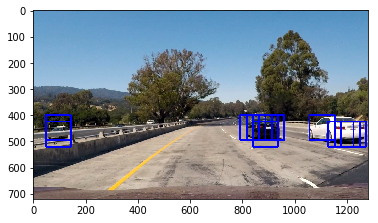

In [4]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, window, cell_per_step):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
        else: 
            ctrans_tosearch = np.copy(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    boxes=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            #subimg = ctrans_tosearch[ytop:ytop+window, xleft:xleft+window]
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            t_f = np.hstack((spatial_features, hist_features, hog_features))
            t_f_r = t_f.reshape(1, -1)
            # Scale features and make a prediction
            test_features = X_scaler.transform(t_f_r)    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return boxes

def boxed_image(img, boxes):
    boxed_img = np.copy(img)
    for box in boxes:
        cv2.rectangle(boxed_img,box[0],box[1],(0,0,255),6)
    return boxed_img

dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
colorspace = dist_pickle["colorspace"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
ystart = 400
ystop = 656
scale = 1.5

print(colorspace)
print(orient)
print(cell_per_block)
print(pix_per_cell)
print(spatial_size)
print(hist_bins)
print(window)
print(cell_per_step)

img = mpimg.imread('test_images/test1.jpg')
boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, window, cell_per_step)
boxed_img = boxed_image(img, boxes)
plt.imshow(boxed_img)

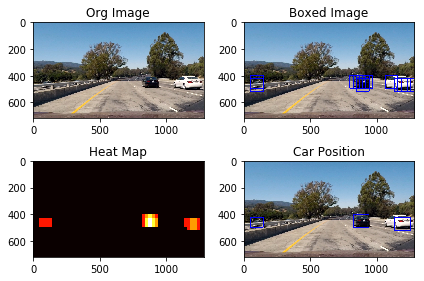

In [5]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat,boxes)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)
boxed_img = boxed_image(img, boxes)

fig = plt.figure()
plt.subplot(221)
plt.imshow(img)
plt.title('Org Image')
plt.subplot(222)
plt.imshow(boxed_img)
plt.title('Boxed Image')
plt.subplot(223)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(224)
plt.imshow(draw_img)
plt.title('Car Position')
fig.tight_layout()

/home/vee/workspace/development/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


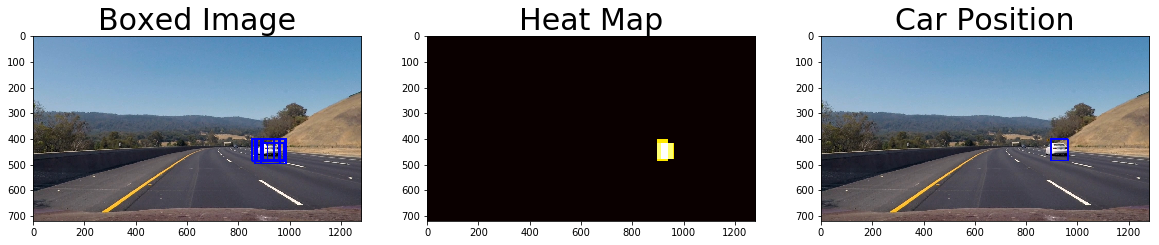

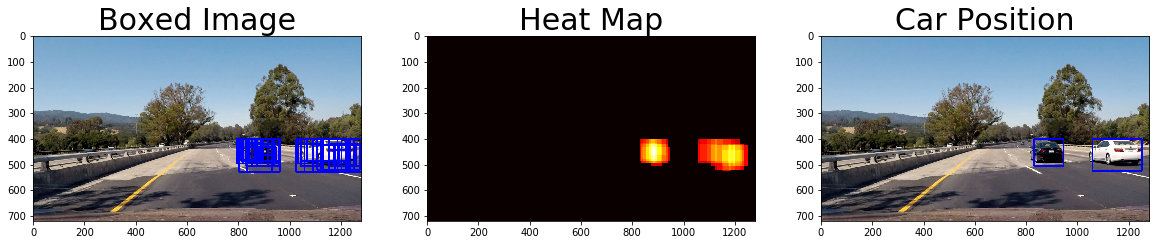

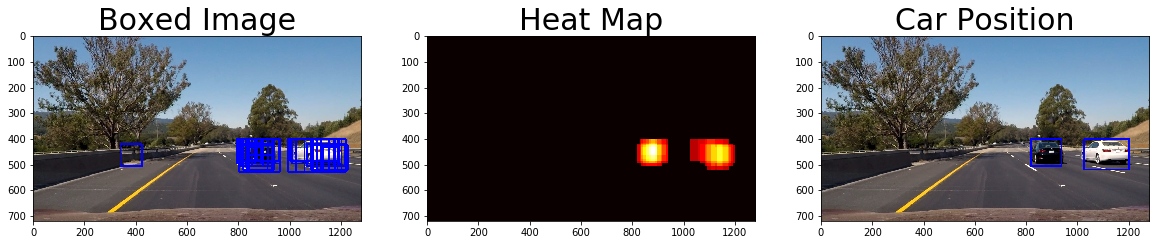

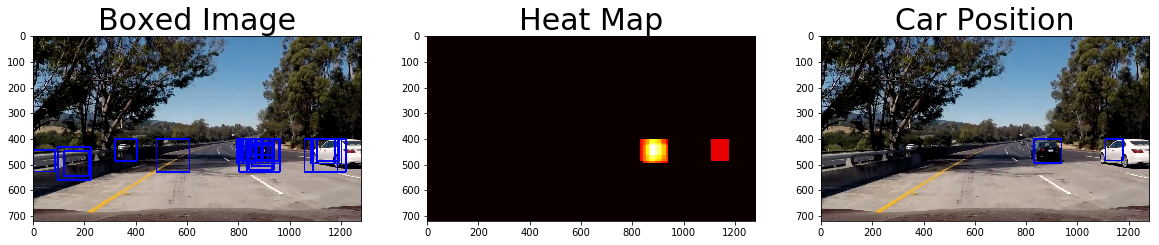

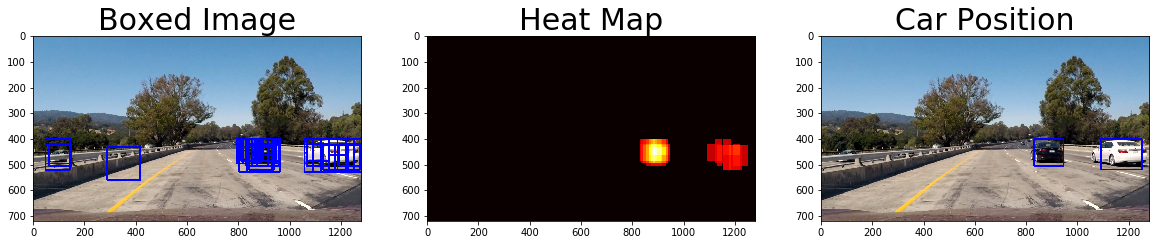

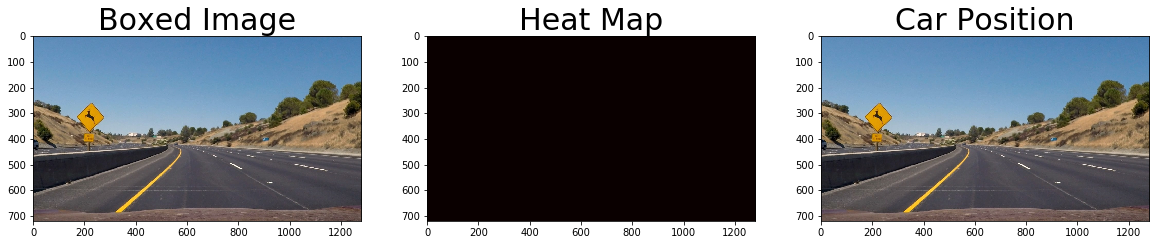

In [6]:
img_list = glob.glob('./test_images/test*.jpg')
scales = [1,1.33, 1.5, 2, 3]
threshold = 4

for img_file in img_list:
    img = mpimg.imread(img_file)
    
    boxes = []
    for scale in scales:
        ystart = 400
        #ystop = ystart + int(window*scale*1.25)
        ystop = 656
        
        scale_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, window, cell_per_step)
        
        if scale_boxes != []:
            boxes += scale_boxes
    #boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, window, cell_per_step)
    # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,boxes)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(boxed_image(img, boxes))
    ax1.set_title('Boxed Image', fontsize=30)
    ax2.imshow(heatmap, cmap='hot')
    ax2.set_title('Heat Map', fontsize=30)
    ax3.imshow(draw_img)
    ax3.set_title('Car Position', fontsize=30)

In [7]:
h = img.shape[0]
w = img.shape[1]
max_frames = 10

class Car():
    def __init__(self):
        self.recent_heat = np.zeros([0, h, w])

In [8]:
car = Car()
def process_image(img):
    boxes = []
    for scale in scales:
        ystart = 400
        ystop = 656
        
        scale_boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, colorspace, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, window, cell_per_step)
        
        if scale_boxes != []:
            boxes += scale_boxes
    # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,boxes)

    heat = np.expand_dims(heat, axis=0)
    if (car.recent_heat.shape[0] >= max_frames):
        car.recent_heat = np.delete(car.recent_heat, 0, 0)
        
    car.recent_heat = np.append(car.recent_heat,heat,axis=0)
    avg_heat = np.average(car.recent_heat, axis=0)
    # Apply threshold to help remove false positives
    heat = apply_threshold(avg_heat,threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'output_video/project_video.mp4'
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [44:47<00:02,  2.43s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

CPU times: user 45min 56s, sys: 23 s, total: 46min 19s
Wall time: 44min 49s


<Container object of 2 artists>

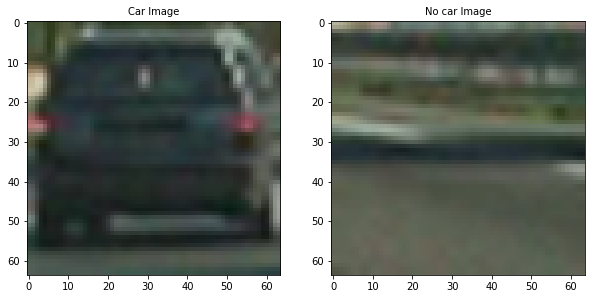

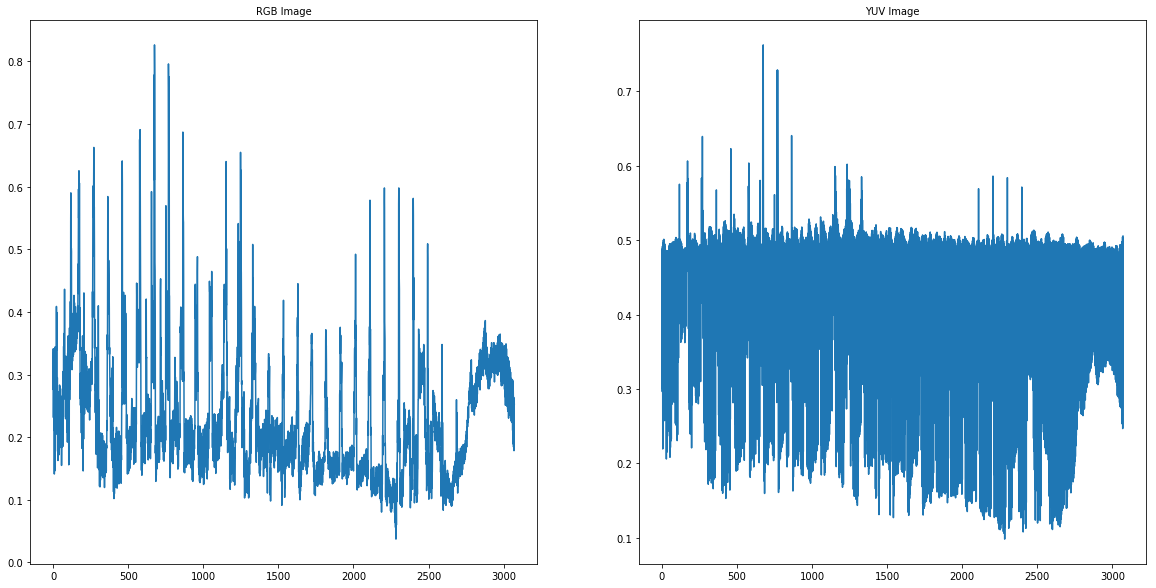

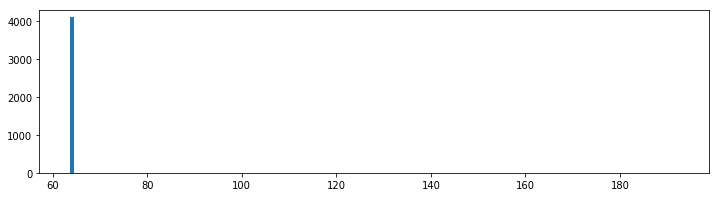

In [38]:
# Experiments
car_image = mpimg.imread(cars[4]) 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(car_image)
ax1.set_title('Car Image', fontsize=10)
ax2.imshow(mpimg.imread(notcars[2]))
ax2.set_title('No car Image', fontsize=10)

feature_vec_yuv = bin_spatial(cv2.cvtColor(car_image, cv2.COLOR_RGB2YUV), size=(32, 32))
feature_vec_rgb = bin_spatial(car_image, size=(32, 32))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.plot(feature_vec_rgb)
ax1.set_title('RGB Image', fontsize=10)
ax2.plot(feature_vec_yuv)
ax2.set_title('YUV Image', fontsize=10)

img = cv2.cvtColor(car_image, cv2.COLOR_RGB2YUV)
bins_range=(0, 256)
hist1 = np.histogram(img[:,:,0], bins=2, range=bins_range)
hist2 = np.histogram(img[:,:,1], bins=2, range=bins_range)
hist3 = np.histogram(img[:,:,2], bins=2, range=bins_range)
bin_edges = hist1[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

fig = plt.figure(figsize=(12,3))
#plt.subplot(131)
plt.bar(bin_centers, hist2[0])
#plt.title('R Histogram')
#plt.subplot(132)
#plt.bar(bin_centers, hist2[0])
#plt.title('G Histogram')
#plt.subplot(133)
#plt.bar(bin_centers, hist3[0])
#plt.title('B Histogram')

